# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data

In [3]:
train_x = np.linspace(0, 1, 58)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((58,), (58, 3))

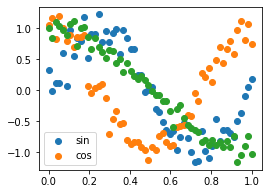

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["sin", "cos"])

In [6]:
x = train_x
xx = np.concatenate((x, x, x), axis=0)[:,None]
n = len(x)
idx2 = np.ones(n) + 1
idx = np.concatenate((np.zeros(n), np.ones(n), idx2))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((train_y[:,0], train_y[:,1], train_y[:,2]))
x.shape, X.shape, y.shape

((58,), (174, 2), (174,))

### Pymc model

In [7]:
X.shape, y.shape

((174, 2), (174,))

In [8]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=2, beta=0.5)
    cov2 = eta**2 * pm.gp.cov.Matern32(2, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    W2 = pm.Normal("W2", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa2 = pm.Gamma("kappa2", alpha=1.5, beta=1, shape=3)
    coreg2 = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa2, W=W2)
    
    cov_func1 = coreg * cov #pm.gp.cov.Prod([coreg, cov])
    cov_func2 = coreg2 * cov2 #pm.gp.cov.Prod([coreg2, cov2])
    cov_func = cov_func1 + cov_func2 #pm.gp.cov.Add([cov_func1, cov_func2])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

In [9]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, W2, kappa2, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 497 seconds.


CPU times: user 14min 47s, sys: 28min 54s, total: 43min 41s
Wall time: 8min 30s


In [10]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
xx_new = np.concatenate((x_new, x_new, x_new), axis=0)
idx2 = np.ones(200) + 1
idx2 = np.concatenate((np.zeros(200), np.ones(200), idx2))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [11]:
X_new.shape

(600, 2)

In [12]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

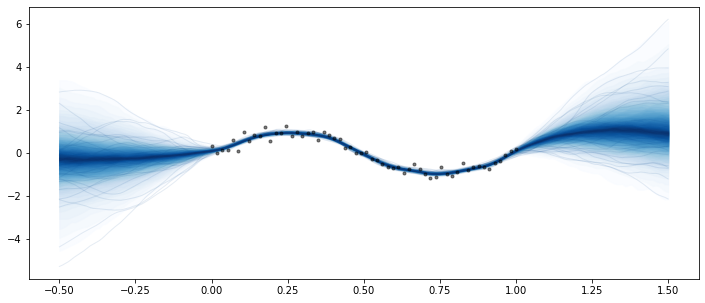

In [13]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

(-4.0, 4.0)

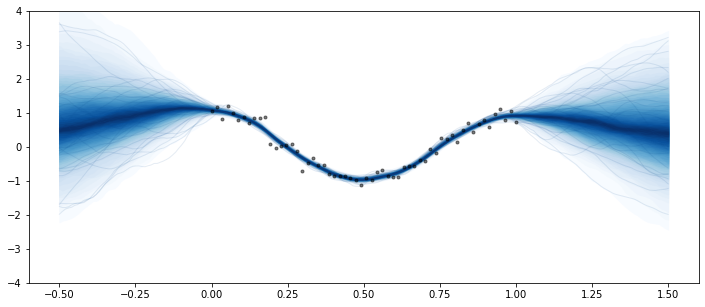

In [14]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,200:400], X_new[200:400,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

(-4.0, 4.0)

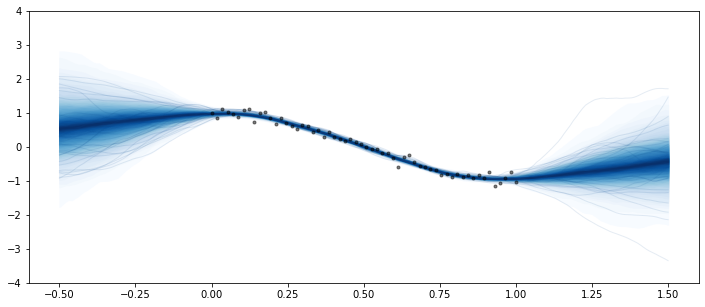

In [15]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,400:], X_new[400:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,2], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [16]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.107,2.964,-5.838,5.403,0.152,0.114,382.0,400.0,NaN
"W[0, 1]",0.139,2.828,-4.773,5.198,0.138,0.119,414.0,329.0,NaN
"W[1, 0]",0.020,3.224,-6.148,5.967,0.185,0.154,307.0,295.0,NaN
"W[1, 1]",0.080,3.222,-6.063,5.673,0.214,0.151,225.0,366.0,NaN
"W[2, 0]",0.116,2.642,-4.669,4.901,0.166,0.117,254.0,291.0,NaN
"W[2, 1]",0.221,2.606,-4.739,4.601,0.152,0.107,306.0,315.0,NaN
"W2[0, 0]",-0.014,3.326,-5.833,5.481,0.276,0.196,142.0,336.0,NaN
"W2[0, 1]",-0.144,3.261,-5.622,5.607,0.239,0.169,191.0,296.0,NaN
"W2[1, 0]",0.167,2.626,-4.600,5.029,0.169,0.120,239.0,432.0,NaN
"W2[1, 1]",0.153,2.720,-4.194,5.574,0.215,0.153,160.0,205.0,NaN


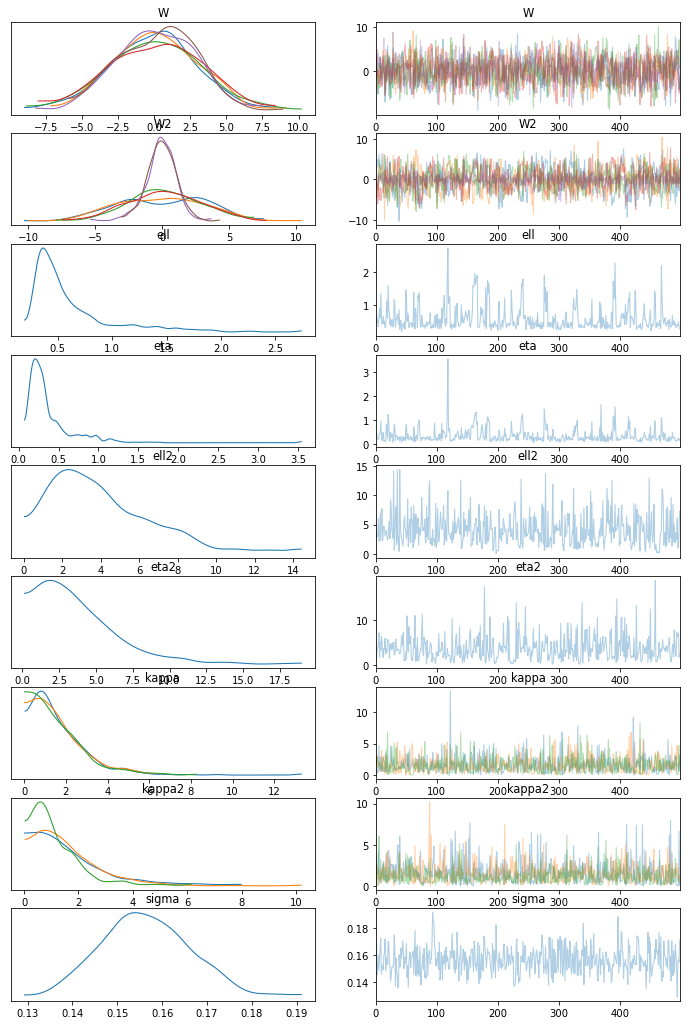

In [17]:
az.plot_trace(gp_trace);